# Bitcoin price prediction
### By: Renáta Kovács
### Supervisor: Petra Krajl Novak

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

In [2]:
pd.set_option('display.max_columns', None)
np.random.seed(42)

## Data

In [3]:
full_data = pd.read_csv('bitcoinhistoricaldata.csv')
full_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,11/18/2025,"93,001.2","92,196.6","93,781.8","89,391.9",115.18K,0.87%
1,11/17/2025,"92,195.0","94,259.8","96,002.7","91,327.8",109.89K,-2.19%
2,11/16/2025,"94,259.8","95,587.6","96,575.1","93,043.5",68.24K,-1.39%
3,11/15/2025,"95,587.6","94,557.5","96,799.5","94,557.5",48.15K,1.09%
4,11/14/2025,"94,554.3","99,707.0","99,843.9","94,126.2",131.30K,-5.19%


In [4]:
full_data.shape

(1844, 7)

In [5]:
def convert_data(df1):
    '''
    converts the dataframe and does feature engineering
    Input:
    df1 - original dataframe
    Returns:
    df - modified dataframe
    '''
    df = df1.copy()
    # rearrange the dataset
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')

    # strip the data
    df['Price'] = (df['Price'].str.replace(',', '')).astype(float)
    df['Open'] = (df['Open'].str.replace(',', '')).astype(float)
    df['High'] = (df['High'].str.replace(',', '')).astype(float)
    df['Low'] = (df['Low'].str.replace(',', '')).astype(float)
    df['Change %'] = (df['Change %'].str.replace('%', '')).astype(float)
    df['Vol.'] = (df['Vol.'].str.replace('K', '0').str.replace('M', '0000').str.replace('B', '0000000').str.replace('.', '')).astype(int)

    # feature engineering
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.weekday
    df['Quarter'] = df['Date'].dt.quarter
    df['Avg_3'] = df['Price'].rolling(window = 3).mean()
    df['Avg_7'] = df['Price'].rolling(window = 7).mean()
    df['Avg_14'] = df['Price'].rolling(window = 14).mean()

    # set index
    df = df.set_index('Date')
    return df

In [6]:
def scale_num(df1):
    '''
    logarithmic scaling of certain numerical values
    Input:
    df1 - original dataframe
    Returns:
    df - scaled dataframe
    '''
    df = df1.copy()
    # log numerical variables
    df['Price'] = np.log(df['Price'])
    df['Open'] = np.log(df['Open'])
    df['High'] = np.log(df['High'])
    df['Low'] = np.log(df['Low'])

    return df


In [7]:
full_data = convert_data(df1 = full_data)
final_data = scale_num(df1 = full_data)

In [8]:
final_data.isna().sum()

Price         0
Open          0
High          0
Low           0
Vol.          0
Change %      0
Year          0
Month         0
Day           0
DayOfWeek     0
Quarter       0
Avg_3         2
Avg_7         6
Avg_14       13
dtype: int64

## Descriptive Statistics

Text(0.5, -0.01, 'Figure 1')

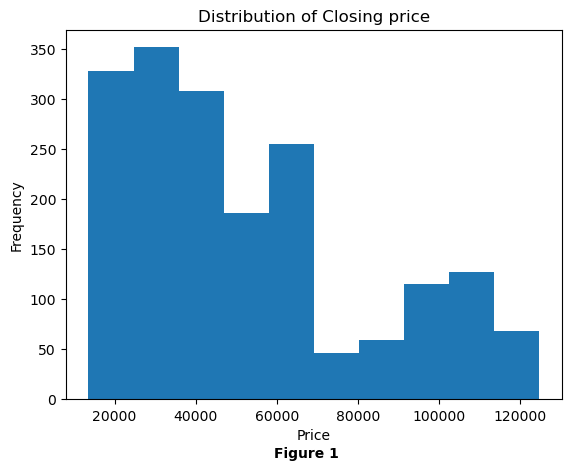

In [9]:
full_data['Price'].hist(grid = False)
plt.title('Distribution of Closing price', fontsize = 12)
plt.xlabel('Price', fontsize = 10)
plt.ylabel('Frequency', fontsize = 10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.figtext(0.5, -0.01, 'Figure 1', ha = 'center', fontsize = 10, weight = 'bold')

Text(0.5, -0.01, 'Figure 3.1')

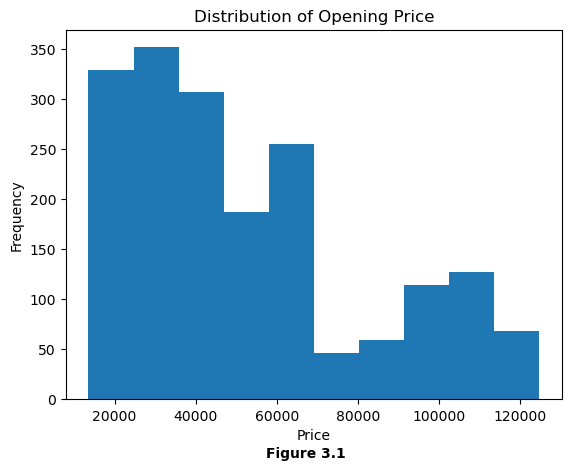

In [10]:
full_data['Open'].hist(grid = False)
plt.title('Distribution of Opening Price', fontsize = 12)
plt.xlabel('Price', fontsize = 10)
plt.ylabel('Frequency', fontsize = 10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.figtext(0.5, -0.01, 'Figure 3.1', ha = 'center', fontsize = 10, weight = 'bold')

Text(0.5, -0.01, 'Figure 3.2')

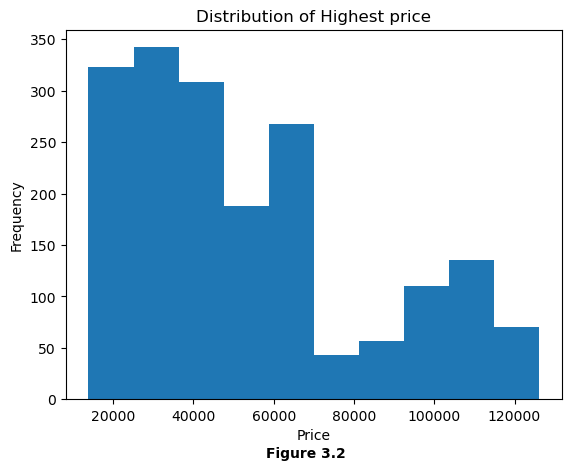

In [11]:
full_data['High'].hist(grid = False)
plt.title('Distribution of Highest price', fontsize = 12)
plt.xlabel('Price', fontsize = 10)
plt.ylabel('Frequency', fontsize = 10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.figtext(0.5, -0.01, 'Figure 3.2', ha = 'center', fontsize = 10, weight = 'bold')

Text(0.5, -0.01, 'Figure 3.3')

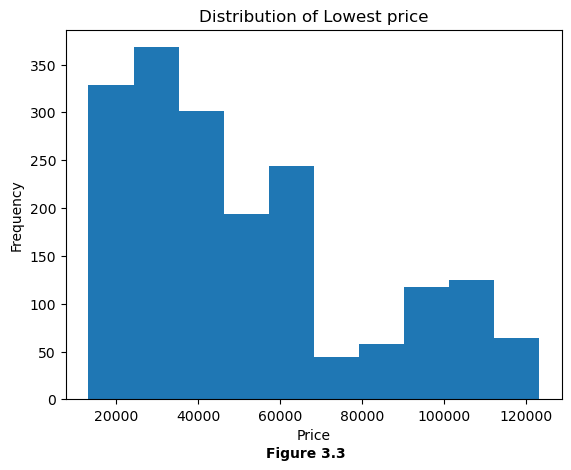

In [12]:
full_data['Low'].hist(grid = False)
plt.title('Distribution of Lowest price', fontsize = 12)
plt.xlabel('Price', fontsize = 10)
plt.ylabel('Frequency', fontsize = 10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.figtext(0.5, -0.01, 'Figure 3.3', ha = 'center', fontsize = 10, weight = 'bold')

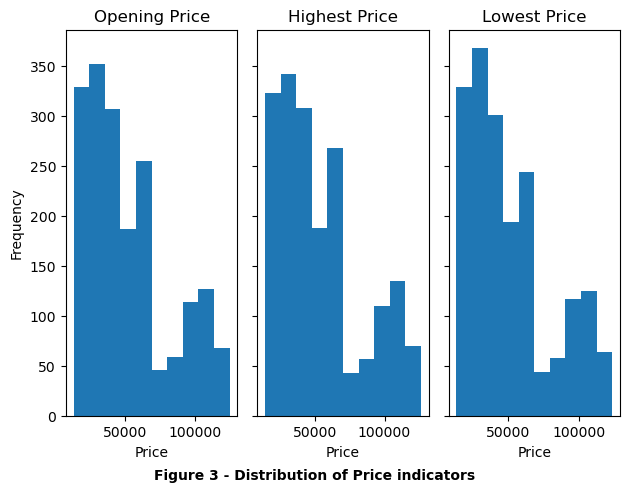

In [13]:
fig, ax = plt.subplots(1,3, sharey = True)

ax[0].hist(full_data['Open'])
ax[0].set_title('Opening Price', fontsize = 12)
ax[0].set_xlabel('Price', fontsize = 10)
ax[0].set_ylabel('Frequency', fontsize = 10)
ax[0].tick_params(axis = 'both', labelsize = 10)

ax[1].hist(full_data['High'])
ax[1].set_title('Highest Price', fontsize = 12)
ax[1].set_xlabel('Price', fontsize = 10)
ax[1].tick_params(axis = 'both', labelsize = 10)

ax[2].hist(full_data['Low'])
ax[2].set_title('Lowest Price', fontsize = 12)
ax[2].set_xlabel('Price', fontsize = 10)
ax[2].tick_params(axis = 'both', labelsize = 10)

fig.text(0.5, -0.01, 'Figure 3 - Distribution of Price indicators', ha = 'center', fontsize = 10, weight = 'bold')
plt.tight_layout()

Text(0.5, -0.01, 'Figure 4')

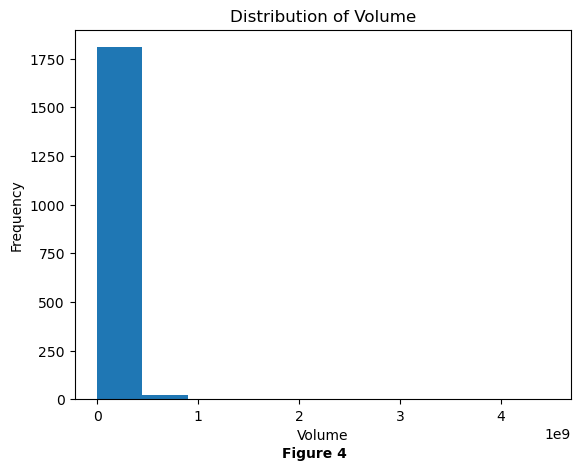

In [14]:
full_data['Vol.'].hist(grid = False)
plt.title('Distribution of Volume', fontsize = 12)
plt.xlabel('Volume', fontsize = 10)
plt.ylabel('Frequency', fontsize = 10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.figtext(0.5, -0.01, 'Figure 4', ha = 'center', fontsize = 10, weight = 'bold')

Text(0.5, -0.01, 'Figure 5')

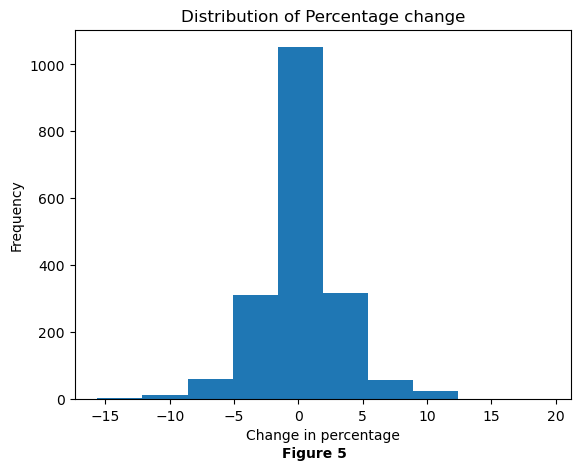

In [15]:
full_data['Change %'].hist(grid = False)
plt.title('Distribution of Percentage change', fontsize = 12)
plt.xlabel('Change in percentage', fontsize = 10)
plt.ylabel('Frequency', fontsize = 10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.figtext(0.5, -0.01, 'Figure 5', ha = 'center', fontsize = 10, weight = 'bold')

In [16]:
full_data.describe()

,Price,Open,High,Low,Vol.,Change %,Year,Month,Day,DayOfWeek,Quarter,Avg_3,Avg_7,Avg_14
count,1844.000000,1844.000000,1844.000000,1844.000000,1.844000e+03,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1842.000000,1838.000000,1831.000000
mean,52453.415239,52410.554176,53467.304935,51296.974729,3.291421e+07,0.151903,2022.854664,6.567245,15.667028,2.998915,2.523319,52452.590572,52448.424569,52428.571214
std,29480.933747,29479.021978,29872.546198,29053.941631,2.537489e+08,3.112637,1.471201,3.460706,8.794993,2.001898,1.121486,29449.403800,29393.613945,29282.895211
min,13561.400000,13560.500000,13828.400000,13214.200000,2.600000e+02,-15.630000,2020.000000,1.000000,1.000000,0.000000,1.000000,13780.233333,14497.100000,15141.421429
25%,28151.800000,28105.400000,28595.525000,27575.050000,5.198750e+04,-1.290000,2022.000000,4.000000,8.000000,1.000000,2.000000,28048.733333,28100.121429,28174.807143
50%,43874.750000,43849.900000,44625.100000,42747.750000,8.036000e+04,0.025000,2023.000000,7.000000,16.000000,3.000000,3.000000,43749.583333,43526.742857,43801.485714
75%,66907.675000,66870.550000,67996.500000,65613.000000,1.388100e+05,1.520000,2024.000000,10.000000,23.000000,5.000000,4.000000,66984.775000,66834.600000,66585.089286
max,124725.100000,124687.500000,126186.000000,123144.600000,4.470000e+09,19.410000,2025.000000,12.000000,31.000000,6.000000,4.000000,123529.233333,122735.128571,119003.400000


## Visualization of the Data

Text(0.5, -0.01, 'Figure 2')

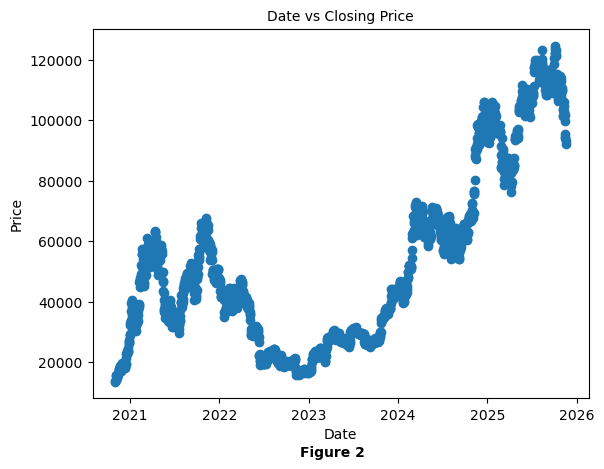

In [17]:
plt.plot(full_data.index, full_data['Price'], marker = 'o', linestyle = '')
plt.title('Date vs Closing Price', fontsize = 10)
plt.xlabel('Date', fontsize = 10)
plt.ylabel('Price', fontsize = 10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.figtext(0.5, -0.01, 'Figure 2', ha = 'center', fontsize = 10, weight = 'bold')

Text(0, 0.5, 'Price')

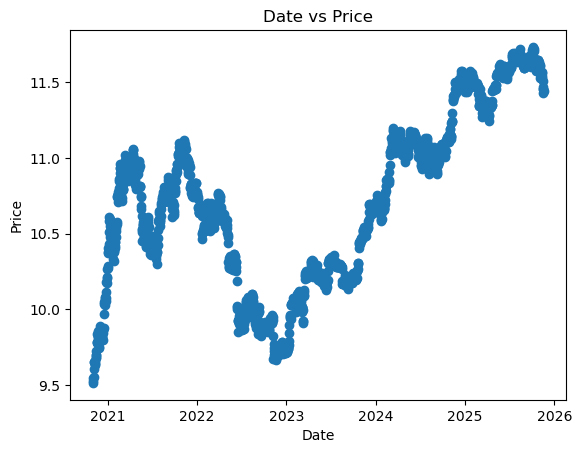

In [18]:
plt.plot(final_data.index, final_data['Price'], marker = 'o', linestyle = '')
plt.title('Date vs Price')
plt.xlabel('Date')
plt.ylabel('Price')


## Split the data and visualize the split

In [19]:
train_nolog = full_data[full_data.index < '2025-08-01']
test_nolog = full_data[full_data.index >= '2025-08-01']

In [20]:
train = final_data[final_data.index < '2025-08-01']
test = final_data[final_data.index >= '2025-08-01']

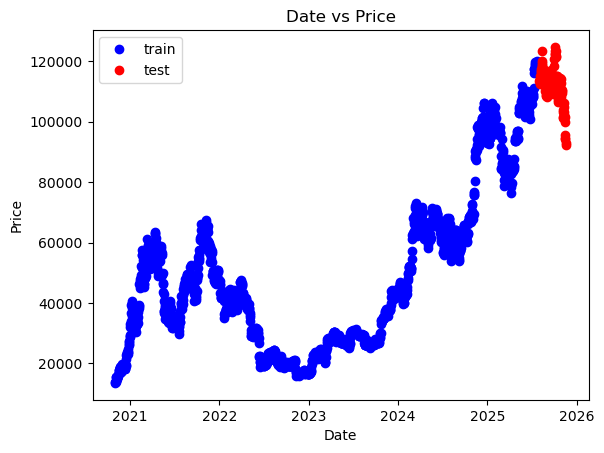

In [21]:
plt.plot(train_nolog.index, train_nolog['Price'], marker = 'o', linestyle = '', color = 'blue', label = 'train')
plt.plot(test_nolog.index, test_nolog['Price'], marker = 'o', linestyle = '', color = 'red', label = 'test')
plt.title('Date vs Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

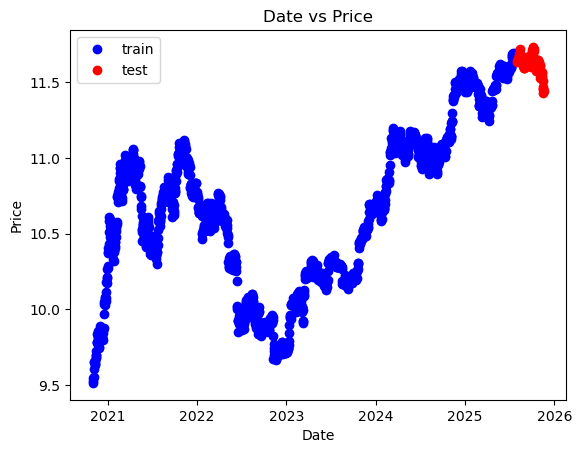

In [22]:
plt.plot(train.index, train['Price'], marker = 'o', linestyle = '', color = 'blue', label = 'train')
plt.plot(test.index, test['Price'], marker = 'o', linestyle = '', color = 'red', label = 'test')
plt.title('Date vs Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

## Set the target and attributes

In [23]:
y_train = train['Price']
X_train = train.drop(['Price'], axis = 1)

In [24]:
y_test = test['Price']
X_test = test.drop(['Price'], axis = 1)

### Scale the volume

In [25]:
scaler = MinMaxScaler()
scaler.fit(X_train[['Vol.']])
X_train['Vol.'] = scaler.transform(X_train[['Vol.']])
X_test['Vol.'] = scaler.transform(X_test[['Vol.']])

In [26]:
X_train.head()

,Open,High,Low,Vol.,Change %,Year,Month,Day,DayOfWeek,Quarter,Avg_3,Avg_7,Avg_14
Date,,,,,,,,,,,,,
2020-11-01,9.532098,9.538888,9.519933,0.000012,-0.27,2020,11,1,6,4,NaN,NaN,NaN
2020-11-02,9.529499,9.534480,9.489047,0.000022,-1.44,2020,11,2,0,4,NaN,NaN,NaN
2020-11-03,9.514916,9.550662,9.495113,0.000024,3.38,2020,11,3,1,4,13780.233333,NaN,NaN
2020-11-04,9.548454,9.563726,9.513728,0.000031,0.90,2020,11,4,2,4,13908.966667,NaN,NaN
2020-11-05,9.557159,9.663954,9.553909,0.000051,10.19,2020,11,5,3,4,14584.200000,NaN,NaN


In [27]:
X_train.shape

(1734, 13)

In [28]:
pd.reset_option('display.max_columns')

## Baseline

C:\Users\renat\AppData\Local\Temp\ipykernel_9800\4253788266.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_nolog['Prev_Price'] = test_nolog['Price'].shift(1)


Text(0.5, -0.125, 'Figure 6 - Baseline')

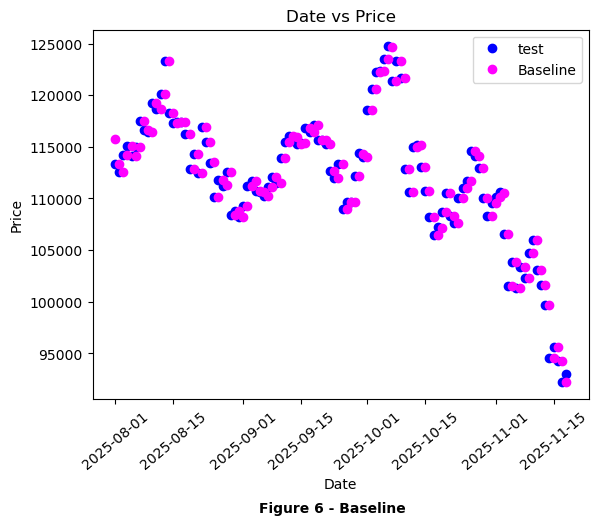

In [29]:
#test_nolog['Average'] = (test_nolog['Open'] + test_nolog['Low'] + test_nolog['High'])/3
test_nolog['Prev_Price'] = test_nolog['Price'].shift(1)
plt.plot(test.index, test_nolog['Price'], marker = 'o', linestyle = '', color = 'blue', label = 'test')
plt.plot(test.index, test_nolog['Open'], marker = 'o', linestyle = '', color = 'magenta', label = 'Baseline')
plt.title('Date vs Price', fontsize = 12)
plt.xlabel('Date', fontsize = 10)
plt.ylabel('Price', fontsize = 10)
plt.xticks(rotation = 40, fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend()
plt.figtext(0.5, -0.125, 'Figure 6 - Baseline', ha = 'center', fontsize = 10, weight = 'bold')

In [30]:
test_nolog.loc[test_nolog.index[0],'Prev_Price'] = train_nolog.loc[train_nolog.index[-1], 'Price']
mae_base = mean_absolute_error(test_nolog['Price'], test_nolog['Open'])
rmse_base = root_mean_squared_error(test_nolog['Price'], test_nolog['Open'])
mse_base = mean_squared_error(test_nolog['Price'], test_nolog['Open'])
print('MAE:', mae_base)
print('RMSE:', rmse_base)
print('MSE:', mse_base)

MAE: 1692.798181818181
RMSE: 2194.1565810952584
MSE: 4814323.102363633


In [31]:
test_nolog.head()

,Price,Open,High,Low,Vol.,Change %,Year,Month,Day,DayOfWeek,Quarter,Avg_3,Avg_7,Avg_14,Prev_Price
Date,,,,,,,,,,,,,,,
2025-08-01,113312.1,115766.7,116054.6,112760.6,77850,-2.12,2025,8,1,4,3,115639.166667,117176.742857,117674.442857,115765.0
2025-08-02,112547.7,113306.4,114050.0,112015.5,38340,-0.67,2025,8,2,5,3,113874.933333,116409.614286,117295.821429,113312.1
2025-08-03,114213.1,112547.9,114758.4,111992.4,27150,1.48,2025,8,3,6,3,113357.633333,115668.900000,117075.528571,112547.7
2025-08-04,115055.3,114213.1,115720.9,114116.1,36550,0.74,2025,8,4,0,3,113938.700000,115240.528571,116908.900000,114213.1
2025-08-05,114139.1,115055.3,115111.7,112678.9,41410,-0.80,2025,8,5,1,3,114469.166667,114696.100000,116492.728571,115055.3


## XGBoost

In [32]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 500, 5000)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    learning_rate = trial.suggest_categorical('learning_rate', [0.2 ,0.1, 0.01, 0.001])
    min_child_weight = trial.suggest_int('min_child_weight', 1, 15)
    reg_alpha = trial.suggest_categorical('reg_alpha', [0, 0.1, 0.5, 1, 5, 10])
    reg_lambda = trial.suggest_categorical('reg_lambda', [0, 0.1, 0.5, 1, 5, 10])
    reg = xgb.XGBRegressor(
        random_state = 42,
        subsample = subsample,
        n_estimators = n_estimators,
        max_depth = max_depth,
        learning_rate = learning_rate,
        min_child_weight = min_child_weight,
        eval_metric = 'rmse',
        reg_alpha = reg_alpha,
        reg_lambda = reg_lambda
    )

    tscv = TimeSeriesSplit(n_splits = 5)
    rmses = []
    for train_index, test_index in tscv.split(X_train):
        train_x = X_train.iloc[train_index]
        train_y = y_train.iloc[train_index]
        test_x = X_train.iloc[test_index]
        test_y = y_train.iloc[test_index]
        reg.fit(train_x, train_y)
        y_pred = reg.predict(test_x)
        score = root_mean_squared_error(y_pred, test_y)
        rmses.append(score)
    return np.mean(rmses)

In [33]:
sampler = optuna.samplers.TPESampler(seed = 42)
study = optuna.create_study(direction = 'minimize', sampler = sampler)
study.optimize(objective, n_trials = 15)

[I 2026-01-31 20:16:56,771] A new study created in memory with name: no-name-513be55a-0e07-4752-9a64-9f2066bbf2dd
[I 2026-01-31 20:17:00,150] Trial 0 finished with value: 0.10483644528879703 and parameters: {'n_estimators': 2185, 'max_depth': 10, 'subsample': 0.8659969709057025, 'learning_rate': 0.2, 'min_child_weight': 13, 'reg_alpha': 1, 'reg_lambda': 1}. Best is trial 0 with value: 0.10483644528879703.
[I 2026-01-31 20:17:05,039] Trial 1 finished with value: 0.1917826722651036 and parameters: {'n_estimators': 3253, 'max_depth': 2, 'subsample': 0.6460723242676091, 'learning_rate': 0.01, 'min_child_weight': 8, 'reg_alpha': 10, 'reg_lambda': 0}. Best is trial 0 with value: 0.10483644528879703.
[I 2026-01-31 20:17:06,874] Trial 2 finished with value: 0.09698951286607753 and parameters: {'n_estimators': 1049, 'max_depth': 5, 'subsample': 0.5171942605576092, 'learning_rate': 0.2, 'min_child_weight': 8, 'reg_alpha': 0.5, 'reg_lambda': 0.1}. Best is trial 2 with value: 0.09698951286607753.


In [34]:
# print out the results
print('Best hyperparameters: ', study.best_params)
print('Best RMSE: ', study.best_value)

Best hyperparameters:  {'n_estimators': 3884, 'max_depth': 1, 'subsample': 0.7530013735702851, 'learning_rate': 0.1, 'min_child_weight': 4, 'reg_alpha': 0, 'reg_lambda': 0.5}
Best RMSE:  0.08220737751654776


In [35]:
reg = xgb.XGBRegressor(n_estimators = 3884, max_depth = 1, subsample = 0.7530013735702851, learning_rate = 0.1, min_child_weight = 4, reg_alpha = 0, reg_lambda = 0.5, random_state = 42, eval_metric = 'rmse')
reg.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'rmse'


In [36]:
y_pred = reg.predict(X_test)
y_pred = np.exp(y_pred)
mae_xgb = mean_absolute_error(test_nolog['Price'], y_pred)
rmse_xgb = root_mean_squared_error(test_nolog['Price'], y_pred)
mse_xgb = mean_squared_error(test_nolog['Price'], y_pred)
print('MAE:', mae_xgb)
print('RMSE:', rmse_xgb)
print('MSE:', mse_xgb)

MAE: 1343.9932386363635
RMSE: 1889.1110250469583
MSE: 3568740.464953969


Text(0.5, -0.125, 'Figure 7 - XGBoost regressor results')

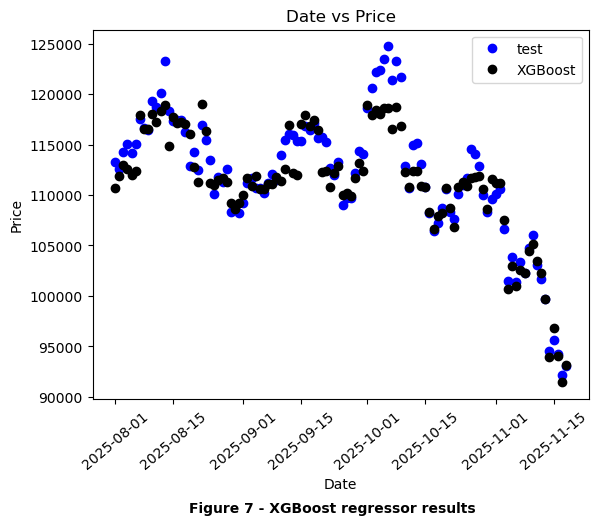

In [37]:
#plt.plot(train['Date'], train['Price'], marker = 'o', linestyle = '', color = 'blue', label = 'train')
plt.plot(test.index, test_nolog['Price'], marker = 'o', linestyle = '', color = 'blue', label = 'test')
plt.plot(test.index, y_pred, marker = 'o', linestyle = '', color = 'black', label = 'XGBoost')
plt.title('Date vs Price', fontsize = 12)
plt.xlabel('Date', fontsize = 10)
plt.ylabel('Price', fontsize = 10)
plt.xticks(rotation = 40, fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend()
plt.figtext(0.5, -0.125, 'Figure 7 - XGBoost regressor results', ha = 'center', fontsize = 10, weight = 'bold')

## Regression Trees

In [38]:
def objective1(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 5000)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    reg1 = RandomForestRegressor(
        random_state = 42,
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_samples_split = min_samples_split,
        criterion = 'squared_error',
        max_features = max_features
    )

    tscv = TimeSeriesSplit(n_splits = 5)
    mses = []
    for train_index, test_index in tscv.split(X_train):
        train_x = X_train.iloc[train_index]
        train_y = y_train.iloc[train_index]
        test_x = X_train.iloc[test_index]
        test_y = y_train.iloc[test_index]
        reg1.fit(train_x, train_y)
        y_pred = reg1.predict(test_x)
        score = mean_squared_error(y_pred, test_y)
        mses.append(score)
    return np.mean(mses)

In [39]:
study = optuna.create_study(direction = 'minimize', sampler = sampler)
study.optimize(objective1, n_trials = 15)

[I 2026-01-31 20:19:06,752] A new study created in memory with name: no-name-bf1acf6f-3178-4fa3-9eaf-f66330c6e689
[I 2026-01-31 20:19:26,613] Trial 0 finished with value: 0.1417382603014362 and parameters: {'n_estimators': 3246, 'max_depth': 1, 'min_samples_split': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.1417382603014362.
[I 2026-01-31 20:19:27,599] Trial 1 finished with value: 0.06612182707380493 and parameters: {'n_estimators': 145, 'max_depth': 2, 'min_samples_split': 7, 'max_features': 'log2'}. Best is trial 1 with value: 0.06612182707380493.
[I 2026-01-31 20:19:53,924] Trial 2 finished with value: 0.026245949043368834 and parameters: {'n_estimators': 2789, 'max_depth': 7, 'min_samples_split': 7, 'max_features': 'log2'}. Best is trial 2 with value: 0.026245949043368834.
[I 2026-01-31 20:20:03,815] Trial 3 finished with value: 0.03443482481036737 and parameters: {'n_estimators': 1262, 'max_depth': 4, 'min_samples_split': 8, 'max_features': 'log2'}. Best is trial 2 

In [40]:
# print out the results
print('Best hyperparameters: ', study.best_params)
print('Best RMSE: ', study.best_value**0.5)

Best hyperparameters:  {'n_estimators': 1783, 'max_depth': 10, 'min_samples_split': 4, 'max_features': 'log2'}
Best RMSE:  0.1577852547378351


In [41]:
reg1 = RandomForestRegressor(n_estimators = 1783, max_depth = 10, min_samples_split = 4, max_features = 'log2', random_state = 42, criterion = 'squared_error')
reg1.fit(X_train, y_train)

,n_estimators,1783
,criterion,'squared_error'
,max_depth,10
,min_samples_split,4
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [42]:
y_pred1 = reg1.predict(X_test)
y_pred1 = np.exp(y_pred1)
mae_re = mean_absolute_error(test_nolog['Price'], y_pred1)
rmse_re = root_mean_squared_error(test_nolog['Price'], y_pred1)
mse_re = mean_squared_error(test_nolog['Price'], y_pred1)
print('MAE:', mae_re)
print('RMSE:', rmse_re)
print('MSE:', mse_re)

MAE: 1772.7913414327115
RMSE: 2254.996804305976
MSE: 5085010.587430164


Text(0.5, -0.125, 'Figure 8 - Random Forest regressor results')

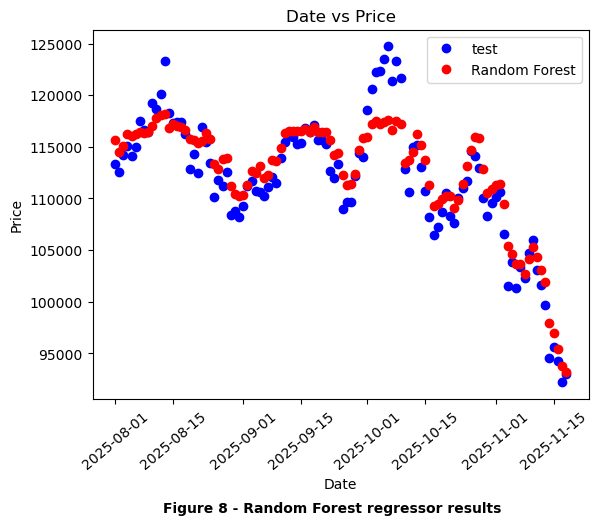

In [43]:
#plt.plot(train['Date'], train['Price'], marker = 'o', linestyle = '', color = 'blue', label = 'train')
plt.plot(test.index, test_nolog['Price'], marker = 'o', linestyle = '', color = 'blue', label = 'test')
plt.plot(test.index, y_pred1, marker = 'o', linestyle = '', color = 'red', label = 'Random Forest')
plt.title('Date vs Price', fontsize = 12)
plt.xlabel('Date', fontsize = 10)
plt.ylabel('Price', fontsize = 10)
plt.xticks(rotation = 40, fontsize = 10)
plt.yticks(fontsize = 10)
plt.legend()
plt.figtext(0.5, -0.125, 'Figure 8 - Random Forest regressor results', ha = 'center', fontsize = 10, weight = 'bold')

## Summary

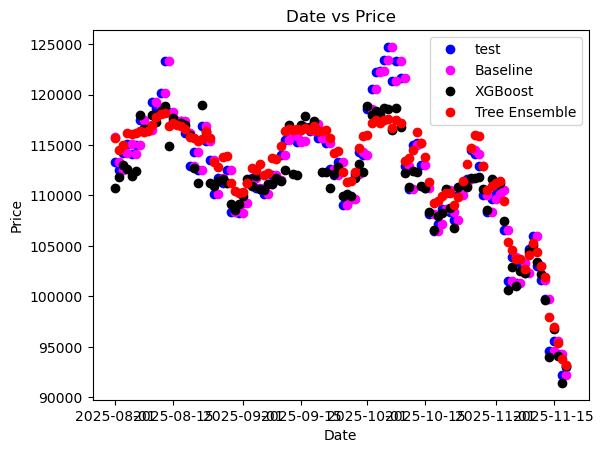

In [44]:
#plt.plot(train['Date'], train['Price'], marker = 'o', linestyle = '', color = 'blue', label = 'train')
plt.plot(test.index, test_nolog['Price'], marker = 'o', linestyle = '', color = 'blue', label = 'test')
plt.plot(test.index, test_nolog['Prev_Price'], marker = 'o', linestyle = '', color = 'magenta', label = 'Baseline')
plt.plot(test.index, y_pred, marker = 'o', linestyle = '', color = 'black', label = 'XGBoost')
plt.plot(test.index, y_pred1, marker = 'o', linestyle = '', color = 'red', label = 'Tree Ensemble')

plt.title('Date vs Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [45]:
print('MAE:', mae_base, mae_xgb, mae_re)
print('MSE:', mse_base, mse_xgb, mse_re)
print('RMSE:', rmse_base, rmse_xgb, rmse_re)

MAE: 1692.798181818181 1343.9932386363635 1772.7913414327115
MSE: 4814323.102363633 3568740.464953969 5085010.587430164
RMSE: 2194.1565810952584 1889.1110250469583 2254.996804305976


In [46]:
print('Model', '\t\t\t\tMAE', '\t\t    MSE', '\t    RMSE')
print('Baseline:\t\t', mae_base, mse_base, rmse_base)
print('XGBoost:\t\t', mae_xgb, mse_xgb, rmse_xgb)
print('Tree Ensemble: \t\t', mae_re, mse_re, rmse_re)

Model 				MAE 		    MSE 	    RMSE
Baseline:		 1692.798181818181 4814323.102363633 2194.1565810952584
XGBoost:		 1343.9932386363635 3568740.464953969 1889.1110250469583
Tree Ensemble: 		 1772.7913414327115 5085010.587430164 2254.996804305976
